In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

# Load a dataset
df = pd.read_csv('cleaned_shelter_data_for_models.csv')

df.head()

,AnimalID,AnimalName,AnimalType,PrimaryColor,SecondaryColor,PrimaryBreed,Sex,DOB,IntakeCondition,IntakeType,...,OutcomeSubtype,OutcomeCondition,Crossing,Jurisdiction,IntakeYear,IntakeMonth,IntakeDay,Time_Spent_In_Shelter_Days,Is_Outcome_After_Intake,Age_Numeric
0,A0569573,SHALE,CAT,BLACK,NaN,DOMESTIC SH,SPAYED,2007-10-12,MED SEV,STRAY,...,U MED SEV,MED SEV,1600 BLOCK ALMADEN RD,SAN JOSE,2024,9,25,0,True,16.0
1,A0719419,NaN,CAT,TABBY-BRN,WHITE,DOMESTIC SH,NEUTERED,NaN,MED R,STRAY,...,U CANCER,MED SEV,MILL POND DR X CANOAS GARDEN AVE,SAN JOSE,2024,8,20,0,True,NaN
2,A0776196,NaN,CAT,PT-LYNX,NaN,DOMESTIC SH,SPAYED,NaN,MED SEV,STRAY,...,U CANCER,MED SEV,E SAN FERNANDO ST/S 34TH ST,SAN JOSE,2024,7,12,0,True,NaN
3,A0820993,NaN,CAT,TABBY-ORG,NaN,DOMESTIC SH,NEUTERED,NaN,AGGRESSIVE,STRAY,...,U MED SEV,MED SEV,CHOPIN AVE X PUCCINI AVE,SAN JOSE,2024,9,11,0,True,NaN
4,A0830781,MOOMOO,CAT,WHITE,GRAY,DOMESTIC SH,SPAYED,2013-03-29,MED R,STRAY,...,NaN,HEALTHY,LEWISTON DR X MIDVALE LN,SAN JOSE,2024,8,21,28,True,11.0


In [3]:
# Convert 'DOB' column to datetime format
df['DOB'] = pd.to_datetime(df['DOB'], errors='coerce')  # Use 'coerce' to handle NaT for missing DOBs

# Calculate Age in years
current_date = pd.to_datetime(datetime.now().date())
df['Age'] = (current_date - df['DOB']).dt.days // 365


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49585 entries, 0 to 49584
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   AnimalID                    49585 non-null  object        
 1   AnimalName                  25098 non-null  object        
 2   AnimalType                  49585 non-null  object        
 3   PrimaryColor                49585 non-null  object        
 4   SecondaryColor              21050 non-null  object        
 5   PrimaryBreed                49585 non-null  object        
 6   Sex                         49585 non-null  object        
 7   DOB                         32599 non-null  datetime64[ns]
 8   IntakeCondition             49585 non-null  object        
 9   IntakeType                  49585 non-null  object        
 10  IntakeSubtype               49211 non-null  object        
 11  IntakeReason                3758 non-null   object    

In [5]:
columns = df.columns
for column in columns:
    print(column)
    print(df[column].nunique())

AnimalID
49585
AnimalName
8754
AnimalType
5
PrimaryColor
53
SecondaryColor
44
PrimaryBreed
318
Sex
5
DOB
5515
IntakeCondition
22
IntakeType
11
IntakeSubtype
26
IntakeReason
53
OutcomeType
4
OutcomeSubtype
259
OutcomeCondition
20
Crossing
21465
Jurisdiction
17
IntakeYear
7
IntakeMonth
12
IntakeDay
31
Time_Spent_In_Shelter_Days
326
Is_Outcome_After_Intake
1
Age_Numeric
29
Age
29


In [6]:
missing_values = df.isnull().sum()
missing_values

,0
AnimalID,0
AnimalName,24487
AnimalType,0
PrimaryColor,0
SecondaryColor,28535
PrimaryBreed,0
Sex,0
DOB,16986
IntakeCondition,0
IntakeType,0


In [7]:
df.describe()

,DOB,IntakeYear,IntakeMonth,IntakeDay,Time_Spent_In_Shelter_Days,Age_Numeric,Age
count,32599,49585.000000,49585.000000,49585.000000,49585.000000,32599.000000,32599.000000
mean,2019-09-22 17:51:30.462897664,2020.924574,6.660159,15.549360,13.767349,5.313967,4.681984
min,1984-08-21 00:00:00,2018.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2018-06-19 00:00:00,2019.000000,5.000000,8.000000,1.000000,3.000000,2.000000
50%,2020-05-20 00:00:00,2021.000000,7.000000,15.000000,6.000000,5.000000,4.000000
75%,2022-05-13 00:00:00,2023.000000,9.000000,23.000000,15.000000,6.000000,6.000000
max,2024-09-20 00:00:00,2024.000000,12.000000,31.000000,726.000000,40.000000,40.000000
std,NaN,1.907012,2.941132,8.780565,28.326146,3.664958,3.856649


In [8]:
# Using KNN to predict the missing data in Age
from sklearn.impute import KNNImputer
import numpy as np

imputer = KNNImputer(n_neighbors=5)
data_imputed = imputer.fit_transform(df[['Age']])
# Round the imputed values to integers
data_imputed = np.round(data_imputed).astype(int)

# Update the original DataFrame with the rounded imputed values
df['Age'] = data_imputed
df['Age']


,Age
0,17
1,5
2,5
3,5
4,11
...,...
49580,6
49581,9
49582,6
49583,5


                                 Age  IntakeYear  IntakeMonth  IntakeDay  \
Age                         1.000000   -0.479466     0.043909  -0.012950   
IntakeYear                 -0.479466    1.000000    -0.237191   0.006059   
IntakeMonth                 0.043909   -0.237191     1.000000  -0.048507   
IntakeDay                  -0.012950    0.006059    -0.048507   1.000000   
Time_Spent_In_Shelter_Days -0.020608    0.134718     0.039343  -0.004907   

                            Time_Spent_In_Shelter_Days  
Age                                          -0.020608  
IntakeYear                                    0.134718  
IntakeMonth                                   0.039343  
IntakeDay                                    -0.004907  
Time_Spent_In_Shelter_Days                    1.000000  


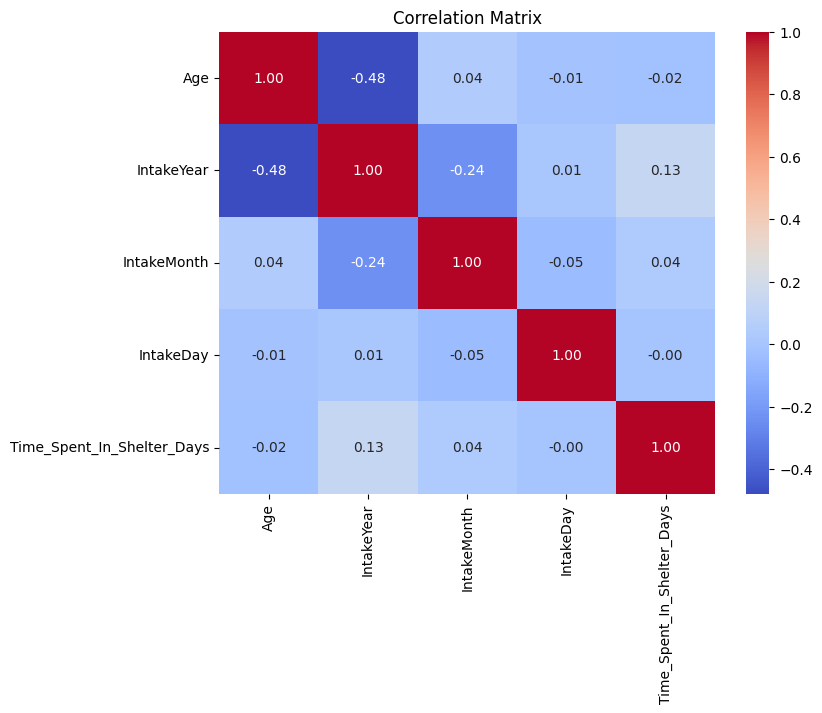

In [9]:
correlation_matrix = df[['Age', 'IntakeYear', 'IntakeMonth', 'IntakeDay', 'Time_Spent_In_Shelter_Days']].corr()
print(correlation_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

<ipython-input-10-d39dca39416e>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duration_outcome_counts = df.groupby(['DurationBin', 'OutcomeType']).size().unstack(fill_value=0)


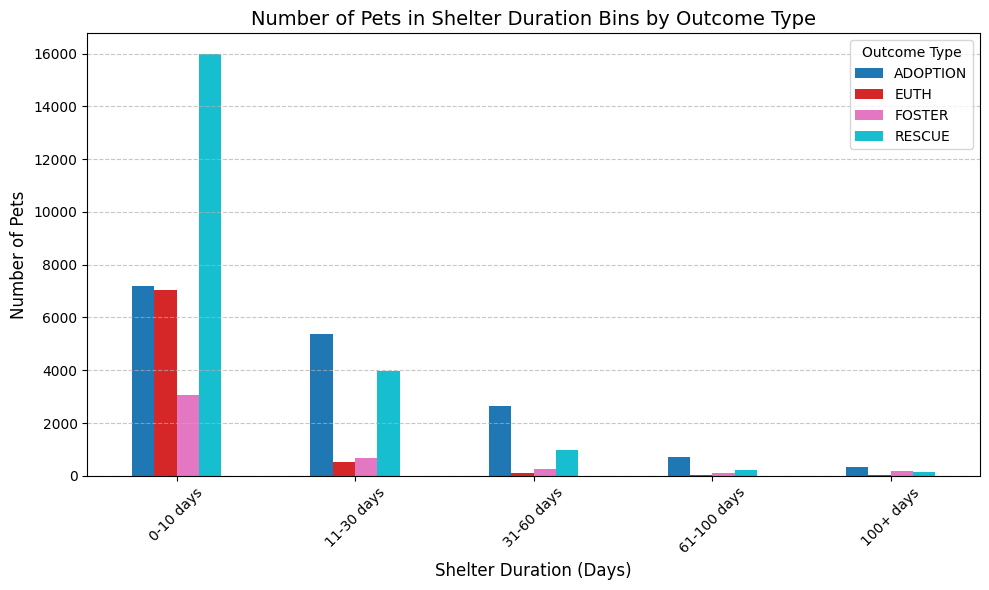

In [10]:
# Define the bins and labels
bins = [-0.1, 10, 30, 60, 100, float("inf")]
labels = ['0-10 days', '11-30 days', '31-60 days', '61-100 days', '100+ days']
df['DurationBin'] = pd.cut(df['Time_Spent_In_Shelter_Days'], bins=bins, labels=labels)

# Count the number of pets in each bin grouped by OutcomeType
duration_outcome_counts = df.groupby(['DurationBin', 'OutcomeType']).size().unstack(fill_value=0)

# Plotting the bar chart
duration_outcome_counts.plot(kind='bar', figsize=(10, 6), colormap='tab10')

# Customize the plot
plt.title('Number of Pets in Shelter Duration Bins by Outcome Type', fontsize=14)
plt.xlabel('Shelter Duration (Days)', fontsize=12)
plt.ylabel('Number of Pets', fontsize=12)
plt.legend(title='Outcome Type', fontsize=10)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

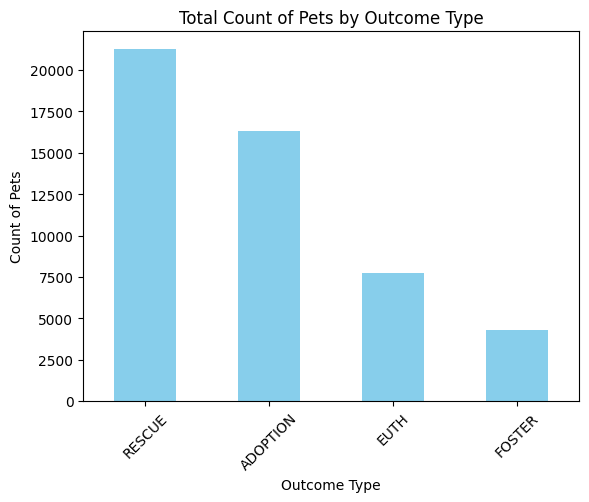

In [11]:
# Group by OutcomeType and count total pets by OutcomeType
outcome_counts = df['OutcomeType'].value_counts()

# Plotting the bar chart
outcome_counts.plot(kind='bar', color='skyblue')
plt.title('Total Count of Pets by Outcome Type')
plt.xlabel('Outcome Type')
plt.ylabel('Count of Pets')
plt.xticks(rotation=45)
plt.show()


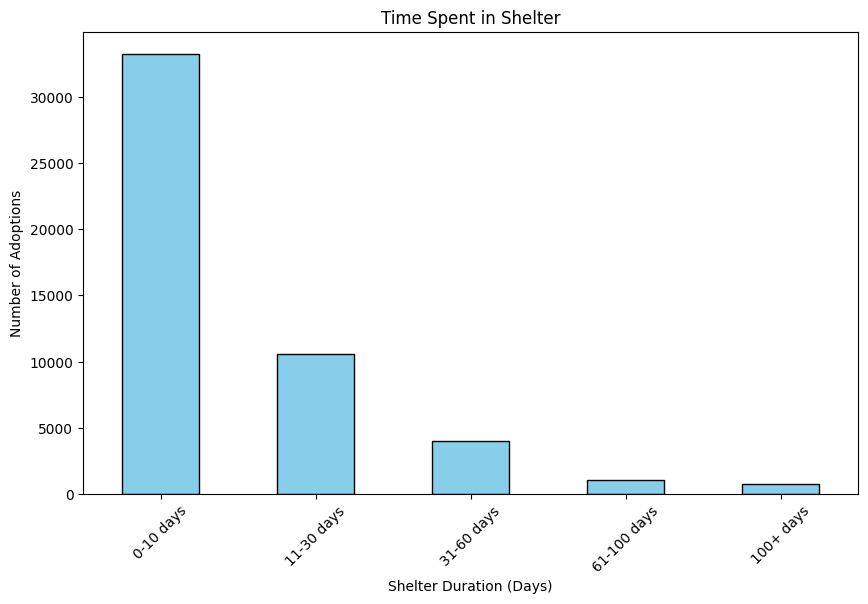

In [12]:
# Bin the shelter duration into categories
bins = [-0.1, 10, 30, 60, 100, float("inf")]
labels = ['0-10 days', '11-30 days', '31-60 days', '61-100 days', '100+ days']
df['DurationBin'] = pd.cut(df['Time_Spent_In_Shelter_Days'], bins=bins, labels=labels)

# Count the number of pets in each bin
duration_counts = df['DurationBin'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))
duration_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Time Spent in Shelter')
plt.xlabel('Shelter Duration (Days)')
plt.ylabel('Number of Adoptions')
plt.xticks(rotation=45)
plt.show()


In [13]:
# Check outliers in time spending in shelter
Q1 = df['Time_Spent_In_Shelter_Days'].quantile(0.25)
Q3 = df['Time_Spent_In_Shelter_Days'].quantile(0.75)
IQR = Q3 - Q1

outliers = df[(df['Time_Spent_In_Shelter_Days'] < (Q1 - 1.5 * IQR)) |
                     (df['Time_Spent_In_Shelter_Days'] > (Q3 + 1.5 * IQR))]
outliers

,AnimalID,AnimalName,AnimalType,PrimaryColor,SecondaryColor,PrimaryBreed,Sex,DOB,IntakeCondition,IntakeType,...,Crossing,Jurisdiction,IntakeYear,IntakeMonth,IntakeDay,Time_Spent_In_Shelter_Days,Is_Outcome_After_Intake,Age_Numeric,Age,DurationBin
39,A1249404,LOUIE,CAT,BLACK,WHITE,DOMESTIC SH,NEUTERED,2016-03-22,HEALTHY,OWNER SUR,...,NaN,OUT OF COUNTY,2024,7,23,37,True,8.0,8,31-60 days
42,A1262901,OPIE,CAT,TABBY-BRN,NaN,DOMESTIC SH,NEUTERED,2022-04-28,MED R,OWNER SUR,...,NaN,SAN JOSE,2024,7,20,45,True,2.0,2,31-60 days
43,A1264381,LADY,CAT,TORTIE-B\O,NaN,DOMESTIC SH,SPAYED,2022-02-07,FERAL,S/N CLINIC,...,NaN,SAN JOSE,2024,7,3,49,True,2.0,2,31-60 days
46,A1287960,LEO,CAT,GRAY,WHITE,DOMESTIC SH,NEUTERED,2022-06-05,BEH M,RETURN,...,NaN,SAN JOSE,2024,7,17,39,True,2.0,2,31-60 days
49,A1293010,BADAMJOON,CAT,BLACK,NaN,DOMESTIC SH,NEUTERED,2023-02-10,HEALTHY,CONFISCATE,...,NaN,SAN JOSE,2024,7,2,46,True,1.0,1,31-60 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49410,A1135337,WILLIAM,DOG,CREAM,NaN,CHIHUAHUA SH,NEUTERED,2017-12-28,OTHER MED,CONFISCATE,...,NaN,SAN JOSE,2019,6,26,52,True,2.0,6,31-60 days
49415,A1135342,TANYA,DOG,TRICOLOR,NaN,CHIHUAHUA SH,SPAYED,2014-06-29,OTHER MED,CONFISCATE,...,NaN,SAN JOSE,2019,6,26,46,True,10.0,10,31-60 days
49417,A1135347,DANIELLA,DOG,CREAM,NaN,CHIHUAHUA SH,SPAYED,2013-06-29,OTHER MED,CONFISCATE,...,NaN,SAN JOSE,2019,6,26,51,True,11.0,11,31-60 days
49578,A1188584,WHITMAN,CAT,BLACK,WHITE,DOMESTIC SH,NEUTERED,2003-10-02,OTHER MED,OWNER SUR,...,NaN,SAN JOSE,2018,9,11,56,True,21.0,21,31-60 days


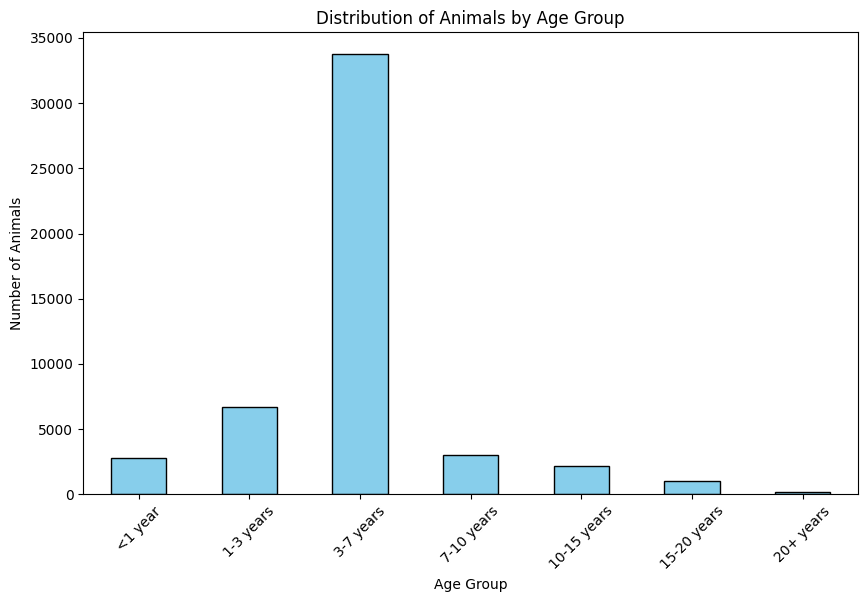

In [14]:
# Define bins and labels
bins = [0, 1, 3, 7, 10, 15, 20, float('inf')]
labels = ['<1 year', '1-3 years', '3-7 years', '7-10 years', '10-15 years', '15-20 years', '20+ years']

# Group ages into bins
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Summarize the counts by age group
age_group_counts = df['AgeGroup'].value_counts().sort_index()

# Visualize the grouped data
plt.figure(figsize=(10, 6))
age_group_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Animals by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Animals')
plt.xticks(rotation=45)
plt.show()

<ipython-input-15-61ad8fbaba0b>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_outcome_counts = df.groupby(['AgeGroup', 'OutcomeType'])['AgeGroup'].count().unstack().fillna(0)


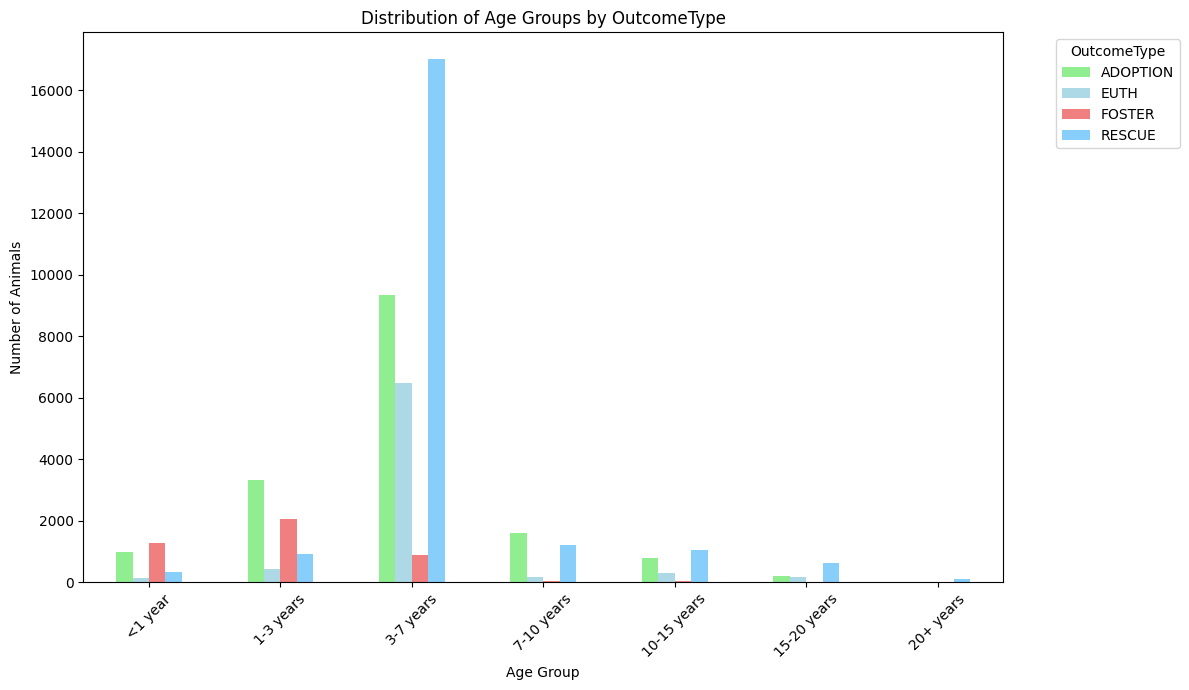

In [15]:
# Group by AgeGroup and OutcomeType and count the occurrences
age_outcome_counts = df.groupby(['AgeGroup', 'OutcomeType'])['AgeGroup'].count().unstack().fillna(0)

# Plotting
age_outcome_counts.plot(kind='bar', figsize=(12, 7), color=['lightgreen', 'lightblue', 'lightcoral', 'lightskyblue'])
plt.title('Distribution of Age Groups by OutcomeType')
plt.xlabel('Age Group')
plt.ylabel('Number of Animals')
plt.xticks(rotation=45)
plt.legend(title='OutcomeType', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [16]:
# Check outliers in Age
Q1 = df['Age'].quantile(0.25)
Q3 = df['Age'].quantile(0.75)
IQR = Q3 - Q1

outliers = df[(df['Age'] < (Q1 - 1.5 * IQR)) |
                     (df['Age'] > (Q3 + 1.5 * IQR))]
outliers

,AnimalID,AnimalName,AnimalType,PrimaryColor,SecondaryColor,PrimaryBreed,Sex,DOB,IntakeCondition,IntakeType,...,Jurisdiction,IntakeYear,IntakeMonth,IntakeDay,Time_Spent_In_Shelter_Days,Is_Outcome_After_Intake,Age_Numeric,Age,DurationBin,AgeGroup
0,A0569573,SHALE,CAT,BLACK,NaN,DOMESTIC SH,SPAYED,2007-10-12,MED SEV,STRAY,...,SAN JOSE,2024,9,25,0,True,16.0,17,0-10 days,15-20 years
4,A0830781,MOOMOO,CAT,WHITE,GRAY,DOMESTIC SH,SPAYED,2013-03-29,MED R,STRAY,...,SAN JOSE,2024,8,21,28,True,11.0,11,11-30 days,10-15 years
5,A0842371,NaN,CAT,TABBY-ORG,NaN,DOMESTIC SH,SPAYED,2011-07-19,MED SEV,STRAY,...,SAN JOSE,2024,7,19,6,True,13.0,13,0-10 days,10-15 years
8,A0897696,BRAVEHEART,CAT,GRAY,NaN,DOMESTIC SH,NEUTERED,2014-03-28,MED M,OWNER SUR,...,SAN JOSE,2024,9,16,7,True,10.0,10,0-10 days,10-15 years
9,A0902350,LOLA,CAT,BLACK,WHITE,DOMESTIC SH,SPAYED,2014-05-11,MED R,STRAY,...,SAN JOSE,2024,8,23,23,True,10.0,10,11-30 days,10-15 years
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49525,A1135732,BABY HUEY,CAT,PT-CHOC,NaN,DOMESTIC SH,NEUTERED,2013-07-02,OTHER MED,STRAY,...,SAN JOSE,2019,6,29,33,True,11.0,11,31-60 days,10-15 years
49533,A1135746,NaN,DOG,WHITE,GRAY,POODLE MIN,FEMALE,2004-07-02,OTHER MED,STRAY,...,MILPITAS,2019,6,29,21,True,20.0,20,11-30 days,20+ years
49535,A1135767,NaN,DOG,TAN,WHITE,CHIHUAHUA SH,FEMALE,2009-07-02,OTHER MED,STRAY,...,SAN JOSE,2019,6,29,11,True,10.0,15,11-30 days,15-20 years
49578,A1188584,WHITMAN,CAT,BLACK,WHITE,DOMESTIC SH,NEUTERED,2003-10-02,OTHER MED,OWNER SUR,...,SAN JOSE,2018,9,11,56,True,21.0,21,31-60 days,20+ years


<ipython-input-17-f8fdeb061bd8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="OutcomeType", y="Time_Spent_In_Shelter_Days", palette="Set2")


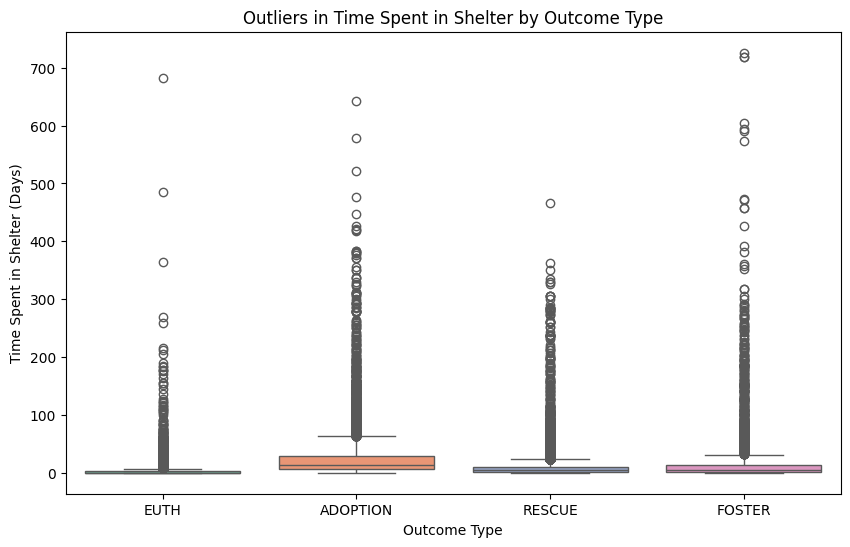

In [17]:
# Set up the figure
plt.figure(figsize=(10, 6))

# Create a box plot to visualize outliers in Time_Spent_In_Shelter_Days
sns.boxplot(data=df, x="OutcomeType", y="Time_Spent_In_Shelter_Days", palette="Set2")

# Add title and labels
plt.title("Outliers in Time Spent in Shelter by Outcome Type")
plt.xlabel("Outcome Type")
plt.ylabel("Time Spent in Shelter (Days)")

# Show plot
plt.show()


<ipython-input-18-063db4570403>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="AnimalType", y="Age", palette="Set2")


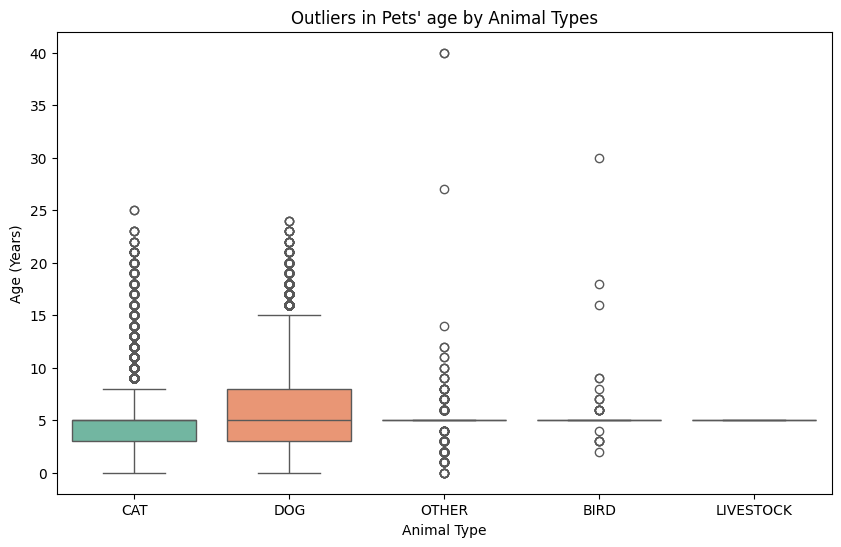

In [18]:
# Set up the figure
plt.figure(figsize=(10, 6))

# Create a box plot to visualize outliers in Time_Spent_In_Shelter_Days
sns.boxplot(data=df, x="AnimalType", y="Age", palette="Set2")

# Add title and labels
plt.title("Outliers in Pets' age by Animal Types")
plt.xlabel("Animal Type")
plt.ylabel("Age (Years)")

# Show plot
plt.show()


In [19]:
df = df.drop(columns=['OutcomeSubtype', 'OutcomeCondition', 'AnimalID', 'AnimalName', 'Age_Numeric', 'Crossing'], axis=1)  # Features (Train set)


In [20]:
# Fill-in missing data
df['IntakeReason'].fillna('Unknown', inplace=True)
df['Jurisdiction'].fillna('Unknown', inplace=True)
df['SecondaryColor'].fillna('Unknown', inplace=True)
df['IntakeSubtype'].fillna('Unknown', inplace=True)

In [21]:
# Frequency Encoding
df['PrimaryColor_freq'] = df['PrimaryColor'].map(df['PrimaryColor'].value_counts())
df['SecondaryColor_freq'] = df['SecondaryColor'].map(df['SecondaryColor'].value_counts())
df['PrimaryBreed_freq'] = df['PrimaryBreed'].map(df['PrimaryBreed'].value_counts())
df['IntakeCondition_freq'] = df['IntakeCondition'].map(df['IntakeCondition'].value_counts())
df['IntakeType_freq'] = df['IntakeType'].map(df['IntakeType'].value_counts())
df['IntakeSubtype_freq'] = df['IntakeSubtype'].map(df['IntakeSubtype'].value_counts())
df['IntakeReason_freq'] = df['IntakeReason'].map(df['IntakeReason'].value_counts())
df['Sex_freq'] = df['Sex'].map(df['Sex'].value_counts())
df['AnimalType_freq'] = df['AnimalType'].map(df['AnimalType'].value_counts())
df['Jurisdiction_freq'] = df['Jurisdiction'].map(df['Jurisdiction'].value_counts())
df.head()

,AnimalType,PrimaryColor,SecondaryColor,PrimaryBreed,Sex,DOB,IntakeCondition,IntakeType,IntakeSubtype,IntakeReason,...,PrimaryColor_freq,SecondaryColor_freq,PrimaryBreed_freq,IntakeCondition_freq,IntakeType_freq,IntakeSubtype_freq,IntakeReason_freq,Sex_freq,AnimalType_freq,Jurisdiction_freq
0,CAT,BLACK,Unknown,DOMESTIC SH,SPAYED,2007-10-12,MED SEV,STRAY,OTC,Unknown,...,12732,28535,27595,1454,41398,38332,45827,13254,32234,43904
1,CAT,TABBY-BRN,WHITE,DOMESTIC SH,NEUTERED,NaT,MED R,STRAY,OTC,Unknown,...,6659,14478,27595,2955,41398,38332,45827,14450,32234,43904
2,CAT,PT-LYNX,Unknown,DOMESTIC SH,SPAYED,NaT,MED SEV,STRAY,OTC,Unknown,...,511,28535,27595,1454,41398,38332,45827,13254,32234,43904
3,CAT,TABBY-ORG,Unknown,DOMESTIC SH,NEUTERED,NaT,AGGRESSIVE,STRAY,OTC,Unknown,...,3166,28535,27595,88,41398,38332,45827,14450,32234,43904
4,CAT,WHITE,GRAY,DOMESTIC SH,SPAYED,2013-03-29,MED R,STRAY,OTC,Unknown,...,5295,768,27595,2955,41398,38332,45827,13254,32234,43904


In [22]:
df['OutcomeType'].value_counts()

,count
OutcomeType,
RESCUE,21267
ADOPTION,16307
EUTH,7708
FOSTER,4303


In [23]:
# Mapping OutcomeType to numerical values
df['OutcomeType_Encoded'] = df['OutcomeType'].map({
    'RESCUE': 0,
    'ADOPTION': 1,
    'EUTH': 2,
    'FOSTER': 3
})

In [24]:
# Label encoding category column
df['Is_Outcome_After_Intake'] = df['Is_Outcome_After_Intake'].astype(int)  # Convert to integers


In [25]:
# Remove columns
df = df.drop(columns = ['AnimalType', 'Sex', 'DOB', 'PrimaryColor', 'SecondaryColor', 'PrimaryBreed', 'IntakeCondition', 'IntakeType', 'IntakeSubtype', 'IntakeReason', 'Jurisdiction', 'AgeGroup', 'DurationBin'])
df.head()

,OutcomeType,IntakeYear,IntakeMonth,IntakeDay,Time_Spent_In_Shelter_Days,Is_Outcome_After_Intake,Age,PrimaryColor_freq,SecondaryColor_freq,PrimaryBreed_freq,IntakeCondition_freq,IntakeType_freq,IntakeSubtype_freq,IntakeReason_freq,Sex_freq,AnimalType_freq,Jurisdiction_freq,OutcomeType_Encoded
0,EUTH,2024,9,25,0,1,17,12732,28535,27595,1454,41398,38332,45827,13254,32234,43904,2
1,EUTH,2024,8,20,0,1,5,6659,14478,27595,2955,41398,38332,45827,14450,32234,43904,2
2,EUTH,2024,7,12,0,1,5,511,28535,27595,1454,41398,38332,45827,13254,32234,43904,2
3,EUTH,2024,9,11,0,1,5,3166,28535,27595,88,41398,38332,45827,14450,32234,43904,2
4,ADOPTION,2024,8,21,28,1,11,5295,768,27595,2955,41398,38332,45827,13254,32234,43904,1


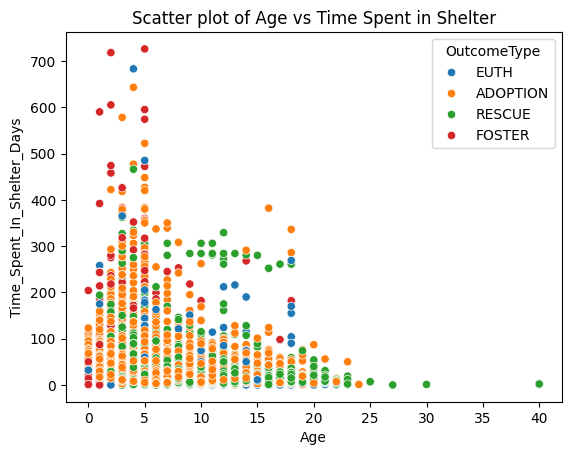

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df, x='Age', y='Time_Spent_In_Shelter_Days', hue='OutcomeType')
plt.title("Scatter plot of Age vs Time Spent in Shelter")
plt.show()


In [27]:
# Pearson Correlation to explore if the relationship is linear or not
correlation_matrix = df[['Age', 'Time_Spent_In_Shelter_Days', 'OutcomeType_Encoded']].corr(method='pearson')
print(correlation_matrix)


                                 Age  Time_Spent_In_Shelter_Days  \
Age                         1.000000                   -0.020608   
Time_Spent_In_Shelter_Days -0.020608                    1.000000   
OutcomeType_Encoded        -0.244589                    0.038998   

                            OutcomeType_Encoded  
Age                                   -0.244589  
Time_Spent_In_Shelter_Days             0.038998  
OutcomeType_Encoded                    1.000000  


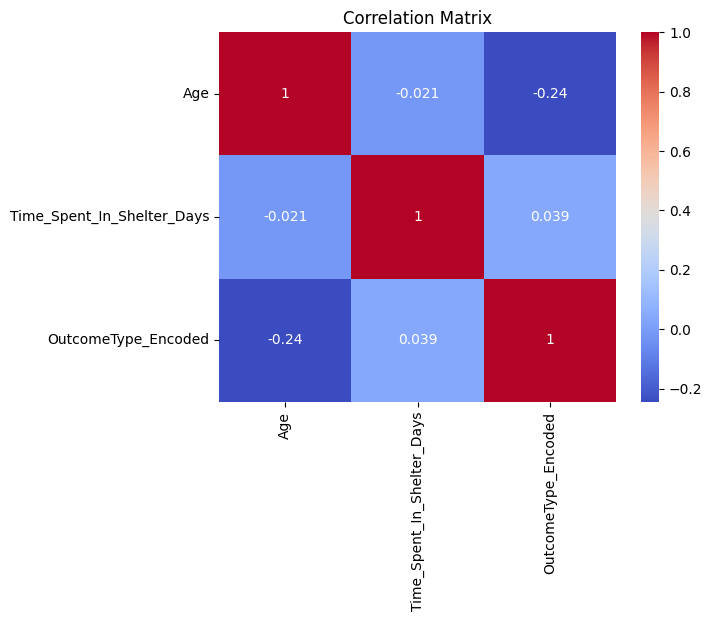

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [29]:
# Drop the 'OutcomeType' column
df = df.drop(columns=['OutcomeType'])
df.head()

,IntakeYear,IntakeMonth,IntakeDay,Time_Spent_In_Shelter_Days,Is_Outcome_After_Intake,Age,PrimaryColor_freq,SecondaryColor_freq,PrimaryBreed_freq,IntakeCondition_freq,IntakeType_freq,IntakeSubtype_freq,IntakeReason_freq,Sex_freq,AnimalType_freq,Jurisdiction_freq,OutcomeType_Encoded
0,2024,9,25,0,1,17,12732,28535,27595,1454,41398,38332,45827,13254,32234,43904,2
1,2024,8,20,0,1,5,6659,14478,27595,2955,41398,38332,45827,14450,32234,43904,2
2,2024,7,12,0,1,5,511,28535,27595,1454,41398,38332,45827,13254,32234,43904,2
3,2024,9,11,0,1,5,3166,28535,27595,88,41398,38332,45827,14450,32234,43904,2
4,2024,8,21,28,1,11,5295,768,27595,2955,41398,38332,45827,13254,32234,43904,1


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'C': 0.47454011884736247}
Classification Report:
              precision    recall  f1-score   support

      Rescue       0.74      0.34      0.47      4253
    Adoption       0.61      0.64      0.63      3261
        EUTH       0.40      0.66      0.50      1542
      Foster       0.37      0.86      0.52       861

    accuracy                           0.54      9917
   macro avg       0.53      0.63      0.53      9917
weighted avg       0.61      0.54      0.53      9917


Confusion Matrix:
[[1454 1188 1315  296]
 [ 214 2097  159  791]
 [ 277   86 1021  158]
 [  12   41   69  739]]

Accuracy Score: 0.5355

Matthews Correlation Coefficient (MCC): 0.3972


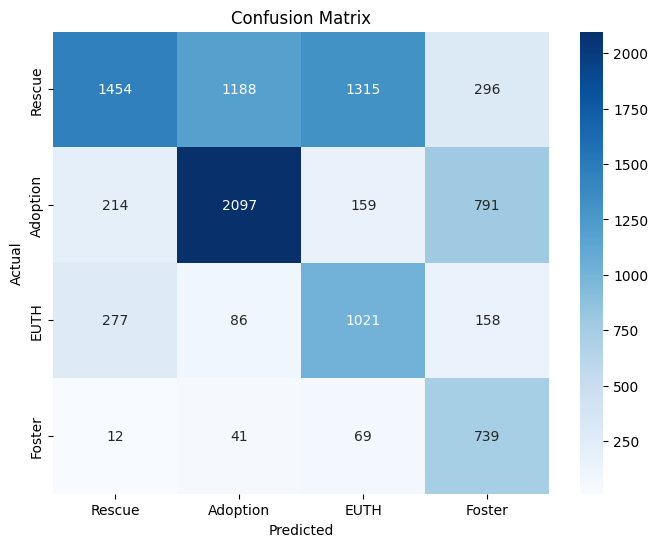

Cross-Validation Scores: [0.62062886 0.63463375 0.64109911 0.6423481  0.63404599]
Mean Cross-Validation Accuracy: 0.6346


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, matthews_corrcoef
from imblearn.over_sampling import SMOTE
from scipy.stats import uniform
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

X = df.drop(columns=['OutcomeType_Encoded'], axis=1)  # Features
y = df['OutcomeType_Encoded']  # Target

# Class names mapping
outcome_mapping = {
    0: "Rescue",
    1: "Adoption",
    2: "EUTH",
    3: "Foster"
}

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE for oversampling on the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'C': uniform(0.1, 1.0),  # Regularization parameter
}

# Initialize the LinearSVC model
svm_model = LinearSVC(max_iter=10000, class_weight='balanced')

# Perform RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(
    svm_model,
    param_distributions=param_dist,
    n_iter=50,  # Number of iterations to sample
    cv=5,       # Number of cross-validation folds
    verbose=1,   # Display progress
    n_jobs=-1,   # Use all CPU cores
    random_state=42
)

# Fit the model with RandomizedSearchCV
random_search.fit(X_train_scaled, y_train_resampled)

# Best parameters from RandomizedSearchCV
print(f"Best hyperparameters: {random_search.best_params_}")

# Train the best LinearSVC model
best_svm_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_svm_model.predict(X_test_scaled)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=outcome_mapping.values()))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy Score: {accuracy:.4f}")

# Calculate MCC
mcc = matthews_corrcoef(y_test, y_pred)
print(f"\nMatthews Correlation Coefficient (MCC): {mcc:.4f}")

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=outcome_mapping.values(), yticklabels=outcome_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Cross-validation scores on the oversampled data
cv_scores = cross_val_score(best_svm_model, X_train_scaled, y_train_resampled, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")


Best hyperparameters: {'C': 1.0737555188414591, 'gamma': 'scale', 'kernel': 'rbf'}
Classification Report:
              precision    recall  f1-score   support

      Rescue       0.80      0.52      0.63      4253
    Adoption       0.67      0.78      0.72      3261
        EUTH       0.59      0.74      0.65      1542
      Foster       0.50      0.84      0.63       861

    accuracy                           0.66      9917
   macro avg       0.64      0.72      0.66      9917
weighted avg       0.70      0.66      0.66      9917


Confusion Matrix:
[[2193 1117  723  220]
 [ 279 2534   44  404]
 [ 234   66 1139  103]
 [  21   85   31  724]]

Accuracy Score: 0.6645

Matthews Correlation Coefficient (MCC): 0.5417


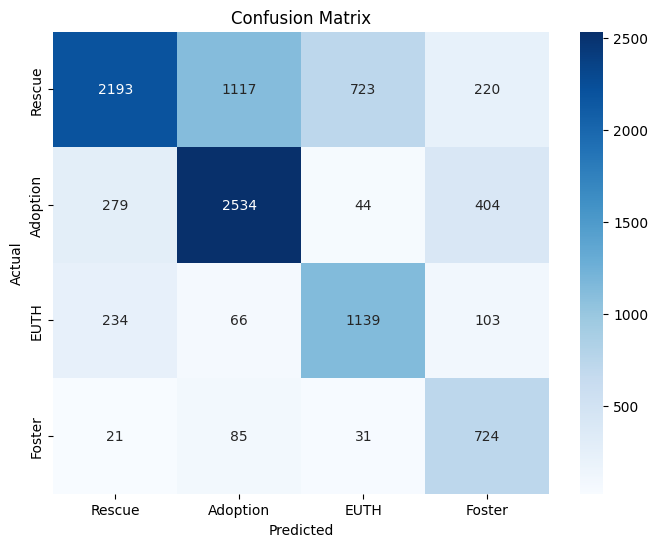

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Con

Cross-Validation Scores: [0.73405818 0.7397693  0.75916538 0.76217765 0.74381015]
Mean Cross-Validation Accuracy: 0.7478


In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, matthews_corrcoef
from imblearn.over_sampling import SMOTE
from scipy.stats import uniform
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# Load your DataFrame (assuming df is already loaded)
X = df.drop(columns=['OutcomeType_Encoded'], axis=1)  # Features
y = df['OutcomeType_Encoded']  # Target

# Class names mapping
outcome_mapping = {
    0: "Rescue",
    1: "Adoption",
    2: "EUTH",
    3: "Foster"
}

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE for oversampling on the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'C': uniform(0.1, 1.0),  # Regularization parameter
    'kernel': ['rbf'],  # Non-linear kernel
    'gamma': ['scale', 'auto']  # Gamma values
}

# Initialize the SVC model
svc_model = SVC(max_iter=10000, class_weight='balanced')

# Define a function to fit the RandomizedSearchCV model
def fit_random_search(svc_model, param_dist, X_train_scaled, y_train_resampled):
    random_search = RandomizedSearchCV(
        svc_model,
        param_distributions=param_dist,
        n_iter=20,  # Number of iterations to sample
        cv=3,  # Number of cross-validation folds
        verbose=1,  # Display progress
        n_jobs=-1,  # Use all CPU cores
        random_state=42,
        scoring='accuracy',
        return_train_score=True
    )
    random_search.fit(X_train_scaled, y_train_resampled)
    return random_search

# Use joblib's Parallel to parallelize the RandomizedSearchCV fitting process
random_search_results = Parallel(n_jobs=-1)(delayed(fit_random_search)(svc_model, param_dist, X_train_scaled, y_train_resampled) for _ in range(1))

# Extract the best random search result
best_random_search = random_search_results[0]

# Print the best hyperparameters
print(f"Best hyperparameters: {best_random_search.best_params_}")

# Train the best SVC model
best_svc_model = best_random_search.best_estimator_

# Make predictions on the test set
y_pred = best_svc_model.predict(X_test_scaled)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=outcome_mapping.values()))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy Score: {accuracy:.4f}")

# Calculate Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, y_pred)
print(f"\nMatthews Correlation Coefficient (MCC): {mcc:.4f}")

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=outcome_mapping.values(), yticklabels=outcome_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Cross-validation scores on the oversampled data
cv_scores = cross_val_score(best_svc_model, X_train_scaled, y_train_resampled, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")
